# LIMPAR DADOS

In [1]:
#importar libs 
import pandas
import numpy

In [2]:
#ler dados
dt_dados_backup=pandas.read_csv('dados.csv',sep=';',decimal=',')

In [3]:
#backup dos dados
dt_dados=dt_dados_backup.copy()

In [4]:
#trocar valores indesejados por nan
dt_dados[dt_dados.isin(['indisponivel',''])]=numpy.nan

In [5]:
#tratar colunas float
colunas_float=['temperatura', 'falta_coleta_lixo', 'falta_controle', 'area_agua_parada_tereno_baldio',
                'taxa_tratamento_esgoto', 'area_acumulo_entulho', 'falta_acesso_servico_saude', 'outros', 
                'conicao_moradia_precaria', 'umidade', 'transp_mercadoria_area_urbana',
                   'precipitacao', 'area_presenca_criadouros', 'migracao_pess_area_endemica']

for coluna in colunas_float:
    #transformar em float
    dt_dados[coluna]=dt_dados[coluna].map(lambda x:float(str(x).replace(',','.')))
    #substituir pela média dos valores
    dt_dados[coluna]=dt_dados[coluna].astype(float).fillna(dt_dados[coluna].mean())


In [6]:
#tratar colunas inteiras
df_col_int=['pres_piscina_s_manut','pres_recipiente_s_tampa','presenca_mosquito']

for coluna in df_col_int:
    #transformar em int
    dt_dados.loc[dt_dados[coluna].isna()==False,coluna]=dt_dados.loc[dt_dados[coluna].isna()==False,coluna].map(lambda x:int(x))
    #substituir pela média dos valores
    dt_dados[coluna]=dt_dados[coluna].fillna(dt_dados[coluna].mean()).astype(int)


In [7]:
#criar index como datetime
dt_dados['id_data']=pandas.to_datetime(dt_dados['id_data'])
dt_dados.set_index('id_data',inplace=True)

# PROPOSTA - CRIACAO DE PARAMETRO

coluna 'chuva_XDias', é uma coluna que apura quantos "X" dias antes do dia referencia temos chuva com "Y" de precipitacao

## parametro de precipitacao

In [8]:
#indicador chuva_XDias - teste de precipitacao
df_teste_precipitar=dt_dados.copy()
teste_precipitar=[]
for i_precipitar in range(10,200):
    dias_precipitacao_maior_que_zero = df_teste_precipitar['precipitacao'].rolling(window=9).apply(lambda x: (x > i_precipitar).sum(), raw=True)
    df_teste_precipitar['chuva_XDias']=dias_precipitacao_maior_que_zero
    correlacao=df_teste_precipitar[['casos_dengue','chuva_XDias']].corr().iloc[0,1]
    teste_precipitar.append([i_precipitar,correlacao])

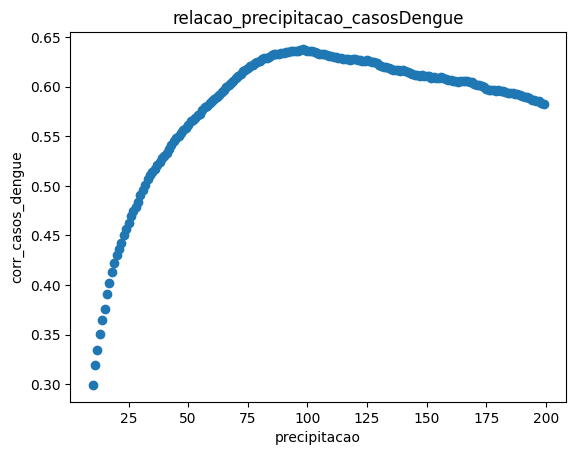

melhor valor


,precipitacao,correlacao
88,98,0.6382


In [9]:
import matplotlib.pyplot as plt
dados=teste_precipitar
# Dados das variáveis
x=[i[0] for i in dados]
y=[i[1] for i in dados]
plt.scatter(x, y)
plt.xlabel('precipitacao')
plt.ylabel('corr_casos_dengue')
plt.title('relacao_precipitacao_casosDengue')
plt.show()

tabela=pandas.DataFrame(teste_precipitar,columns=['precipitacao','correlacao'])
tabela=tabela[tabela['correlacao']==tabela['correlacao'].max()]

print('melhor valor')
display(tabela)

## parametro dias

In [10]:
#indicador chuva_XDias - teste de dias
df_teste_precipitar=dt_dados.copy()
teste_dias=[]
for i_dia in range(0,35):
    dias_precipitacao_maior_que_zero = df_teste_precipitar['precipitacao'].rolling(window=i_dia).apply(lambda x: (x > 97).sum(), raw=True)
    df_teste_precipitar['chuva_XDias']=dias_precipitacao_maior_que_zero
    correlacao=df_teste_precipitar[['casos_dengue','chuva_XDias']].corr().iloc[0,1]
    teste_dias.append([i_dia,correlacao])

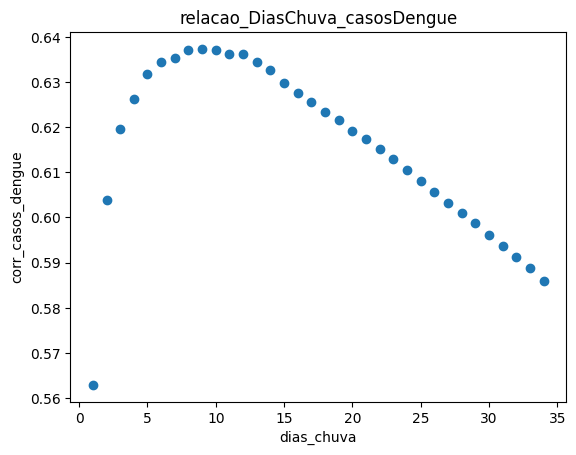

melhor valor


,dias_chuva,correlacao
9,9,0.637328


In [11]:
import matplotlib.pyplot as plt
dados=teste_dias
# Dados das variáveis
x=[i[0] for i in dados]
y=[i[1] for i in dados]
plt.scatter(x, y)
plt.xlabel('dias_chuva')
plt.ylabel('corr_casos_dengue')
plt.title('relacao_DiasChuva_casosDengue')
plt.show()

tabela=pandas.DataFrame(teste_dias,columns=['dias_chuva','correlacao'])
tabela=tabela[tabela['correlacao']==tabela['correlacao'].max()]

print('melhor valor')
display(tabela)

# CRIACAO DA COLUNA COM PARAMETROS AJUSTADOS

In [12]:
#coluna chuva_XD - 
dias_precipitacao_maior_que_zero = dt_dados['precipitacao'].rolling(window=9).apply(lambda x: (x > 98).sum(), raw=True)
dt_dados['chuva_XDias']=dias_precipitacao_maior_que_zero

## comparar correlacao da nova variavel

In [13]:
#comparar correlação
dt_dados[['casos_dengue','temperatura','umidade','precipitacao','chuva_XDias']].corr()

,casos_dengue,temperatura,umidade,precipitacao,chuva_XDias
casos_dengue,1.000000,0.435860,0.443209,0.558106,0.638200
temperatura,0.435860,1.000000,0.484303,0.533262,0.583222
umidade,0.443209,0.484303,1.000000,0.562347,0.614553
precipitacao,0.558106,0.533262,0.562347,1.000000,0.791368
chuva_XDias,0.638200,0.583222,0.614553,0.791368,1.000000


# FATOR TEMPORADA

Criar o fator temporada, é um fator de correção para colunas que não teriam relevância fora do período de dengue: 

'area_presenca_criadouros',area_agua_parada_tereno_baldio','pres_piscina_s_manut','pres_recipiente_s_tampa'

A ideia é ajustar visualmente o fator em faixas de período. Essas faixas são ajustadas por semana.

In [123]:
#coluna de numero de semana
dt_dados['n_week']=dt_dados.index.isocalendar()['week']

In [146]:
#Separar somente as colunas de interesse
colunas=['casos_dengue','n_week',
         'area_presenca_criadouros','area_agua_parada_tereno_baldio',
         'pres_piscina_s_manut','pres_recipiente_s_tampa']
dt_teste=dt_dados[colunas].copy()

### criação do fator temporada

In [177]:
#usar média móvel para eliminar influencia dos outliers
colunas=['area_presenca_criadouros','area_agua_parada_tereno_baldio',
         'pres_piscina_s_manut','pres_recipiente_s_tampa']
for coluna in colunas:
    dt_teste[coluna] = dt_teste[coluna].rolling(window=5).mean()


In [179]:
#criação do fator temporada
alta_temporada=1
media_temporada=0.2
baixa_temporada=0

dt_teste['temporada']=0
dt_teste.loc[dt_teste['n_week'].between(0,14),'temporada']=alta_temporada
dt_teste.loc[dt_teste['n_week'].between(15,23),'temporada']=media_temporada
dt_teste.loc[dt_teste['n_week'].between(24,40),'temporada']=baixa_temporada
dt_teste.loc[dt_teste['n_week'].between(40,48),'temporada']=media_temporada
dt_teste.loc[dt_teste['n_week'].between(49,52),'temporada']=alta_temporada

#usar o fator temporada para corrigir as colunas

colunas=['area_presenca_criadouros','area_agua_parada_tereno_baldio',
         'pres_piscina_s_manut','pres_recipiente_s_tampa']
for i in colunas:
    i2=i+'*'#colunas com "*" no final são as ajustadas com o fator temporada
    dt_teste[i2]=dt_teste[i]*dt_teste['temporada']
    

/tmp/ipykernel_3423/3910726395.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dt_teste.loc[dt_teste['n_week'].between(15,23),'temporada']=media_temporada


In [180]:
#comparar colunas
dt_teste.corr()

,casos_dengue,n_week,area_presenca_criadouros,area_agua_parada_tereno_baldio,pres_piscina_s_manut,pres_recipiente_s_tampa,temporada,area_presenca_criadouros*,area_agua_parada_tereno_baldio*,pres_piscina_s_manut*,pres_recipiente_s_tampa*
casos_dengue,1.000000,-0.279837,0.023596,-0.024746,0.002301,0.007016,0.628410,0.625444,0.624916,0.620879,0.621543
n_week,-0.279837,1.000000,-0.060905,-0.008107,-0.013395,0.027943,-0.452398,-0.454234,-0.454068,-0.448517,-0.435515
area_presenca_criadouros,0.023596,-0.060905,1.000000,-0.021627,-0.003734,-0.012089,0.029347,0.107216,0.032800,0.037261,0.030733
area_agua_parada_tereno_baldio,-0.024746,-0.008107,-0.021627,1.000000,0.006546,-0.019729,-0.062959,-0.058874,0.021988,-0.062570,-0.072639
pres_piscina_s_manut,0.002301,-0.013395,-0.003734,0.006546,1.000000,-0.023282,-0.016083,-0.009095,-0.016379,0.092635,-0.017353
pres_recipiente_s_tampa,0.007016,0.027943,-0.012089,-0.019729,-0.023282,1.000000,-0.003385,-0.001975,-0.011494,-0.004743,0.111473
temporada,0.628410,-0.452398,0.029347,-0.062959,-0.016083,-0.003385,1.000000,0.993123,0.992283,0.987846,0.986382
area_presenca_criadouros*,0.625444,-0.454234,0.107216,-0.058874,-0.009095,-0.001975,0.993123,1.000000,0.986292,0.983035,0.980031
area_agua_parada_tereno_baldio*,0.624916,-0.454068,0.032800,0.021988,-0.016379,-0.011494,0.992283,0.986292,1.000000,0.980152,0.976515
pres_piscina_s_manut*,0.620879,-0.448517,0.037261,-0.062570,0.092635,-0.004743,0.987846,0.983035,0.980152,1.000000,0.974363


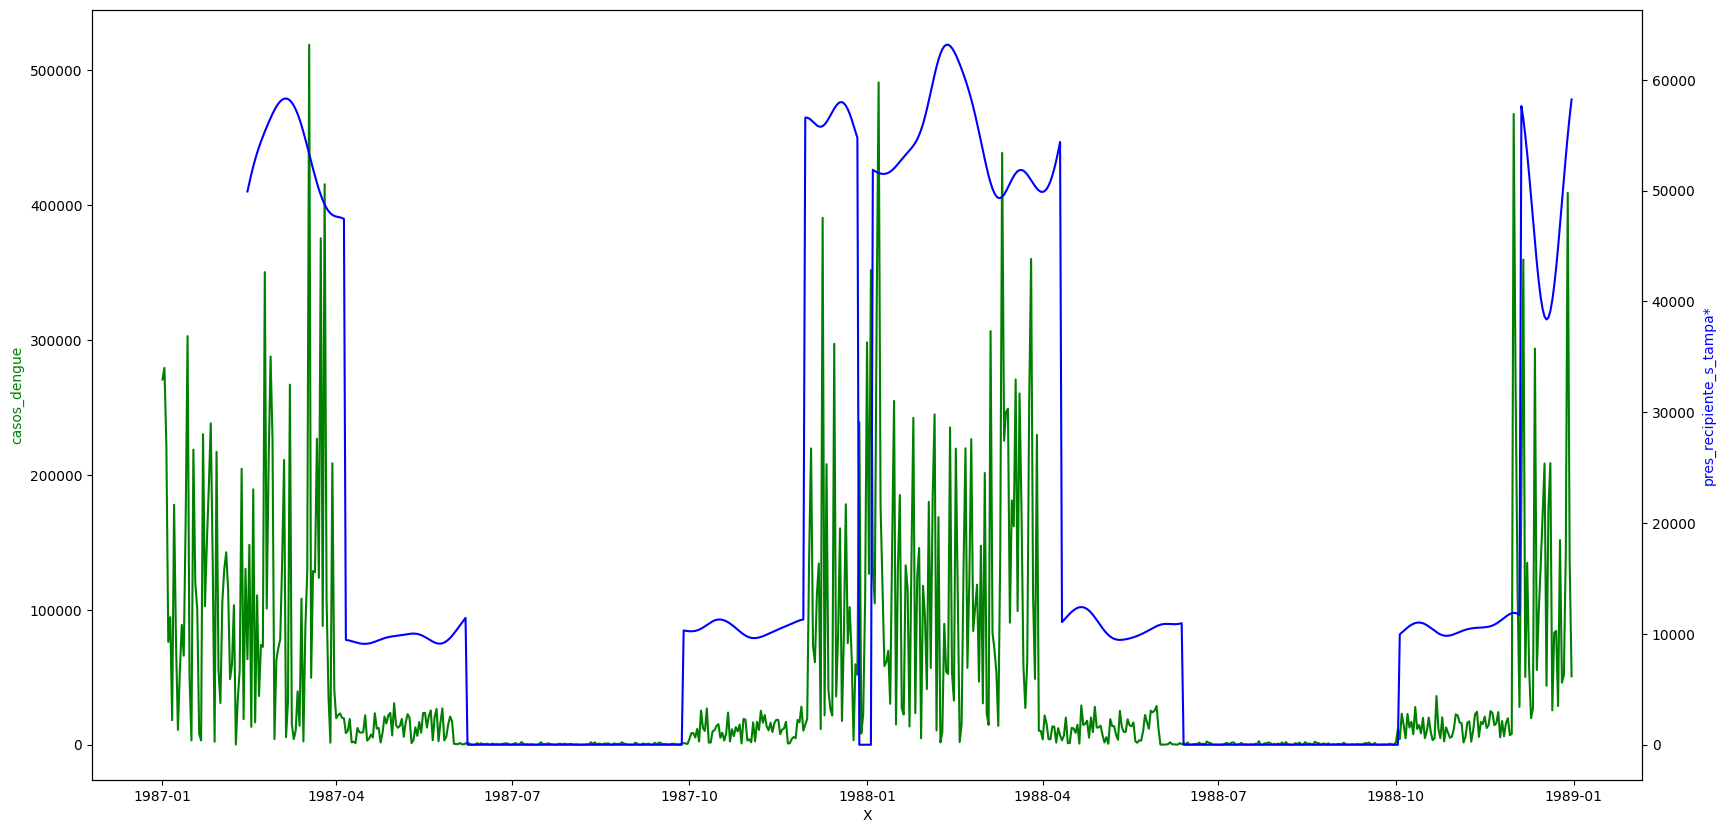

In [181]:
#visualização 
#comparar casos_dengue com as variáveis corrigidas

import matplotlib.pyplot as plt

def plot_multi_axes(x, y1, y2, xlabel, y1label, y2label,figsize=(20,10)):
    # Criar figura e eixos
    fig, ax1 = plt.subplots(figsize=figsize)
    

    # Plotar no primeiro eixo
    ax1.plot(x, y1, 'g-')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color='g')

    # Criar o segundo eixo compartilhando o eixo x
    ax2 = ax1.twinx()
    ax2.plot(x, y2, 'b-')
    ax2.set_ylabel(y2label, color='b')

    
    plt.show()


# Exemplo de uso
datas_filtradas=dt_teste #todos os dias
datas_filtradas = dt_teste[dt_teste.index < '1989-01-01'] #até certo dia
pontos=len(datas_filtradas)

x=dt_teste.index[:pontos] #eixo x
#x=dt_teste['n_week'][:pontos]

yl1='casos_dengue'
y1=dt_teste[yl1][:pontos]

yl2='pres_recipiente_s_tampa*'
y2 = dt_teste[yl2][:pontos]
plot_multi_axes(x, y1, y2, 'X', yl1, yl2)
